In [207]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
# Defining today's day for reference
today = '2016-06-20'
date = pd.to_datetime(today)

# Loading csv extracted from database into a Pandas DataFrame
df = pd.read_csv('dataset.csv', usecols=range(1,17))

# Treating date fields and converting them to datetime timestamp
df.created_at = pd.to_datetime(df['created_at'])
df.last_session = pd.to_datetime(df['last_session'])
df.last_favorited_artwork_date = pd.to_datetime(df['last_favorited_artwork_date'])
df.last_followed_artist_date = pd.to_datetime(df['last_followed_artist_date'])

# Creating function to extract only the days (int) from TimeDelta objects
def extract_days(x):
    try:
        return x.days
    except:
        return 0
    
# New feature: Extracting the difference between last session and today
df['days_from_last_session'] = date - df.last_session
df['days_from_last_session'] = df.days_from_last_session.apply(lambda x: extract_days(x))

# New feature: Extracting the difference between last session and when user registered
df['diff_created_to_last'] = df.last_session - df.created_at
df['diff_created_to_last'] = df.diff_created_to_last.apply(lambda x: extract_days(x))

# New feature: Extracting the difference between last favorited artwork and today
df['diff_last_fav_artwork_to_today'] = date - df.last_favorited_artwork_date
df['diff_last_fav_artwork_to_today'] = df.diff_last_fav_artwork_to_today.apply(lambda x: extract_days(x))

# New feature: Extracting the difference between last artists followed and today
df['diff_last_artist_folw_to_today'] = date - df.last_followed_artist_date
df['diff_last_artist_folw_to_today'] = df.diff_last_artist_folw_to_today.apply(lambda x: extract_days(x))

drop_cols = ['id', 
             'last_sign_in_at', 
             'created_at', 
             'last_session', 
             'last_favorited_artwork_date', 
             'last_followed_artist_date',
             'total_follows',
             'total_favorites',
             'city']

# Dropping columns
df = df.drop(drop_cols, axis=1)

# Filling NaN values with unknown for categorical variables before dummifying
df.gender.fillna('unknown', inplace=True)
df.user_type.fillna('unknown', inplace=True)
df.os.fillna('unknown', inplace=True)

# Dropping about 100 recent user ids missing all information
df.num_sessions.dropna(inplace=True)

# Dropping 3 records based on gender feature
df = df[(df.gender != 'male (hidden)') & (df.gender != 'female (hidden)')]

# Defining some labels for engagement
df['engagement200'] = np.where(df.diff_created_to_last < 200, 1, 0)
# df['engagement15'] = np.where(df.diff_created_to_last < 15, 1, 0)
# df['engagement_now15'] = np.where(df.days_from_last_session < 15, 1, 0)

# Dummifying categorical variables (gender, user_type, and os)
df = pd.concat([df, pd.get_dummies(df.gender, prefix='gender', drop_first=True)], axis=1)
df = df.drop('gender', axis=1)

# df = pd.concat([df, pd.get_dummies(df.user_type, prefix='user_type', drop_first=True)], axis=1)
df = df.drop('user_type', axis=1)

# df = pd.concat([df, pd.get_dummies(df.os, prefix='os', drop_first=True)], axis=1)
df = df.drop('os', axis=1)

# Finally dropping off random Na values (101 records)
df.dropna(inplace=True)

# Dropping column used to create the label:
df.drop('days_from_last_session', axis=1, inplace=True)

In [180]:
list(df.columns)

['num_sessions',
 'total_artists_followed',
 'total_artworks_favorited',
 'total_artworks_shared',
 'diff_created_to_last',
 'diff_last_fav_artwork_to_today',
 'diff_last_artist_folw_to_today',
 'engagement200',
 'gender_male',
 'gender_unknown']

In [181]:
df.drop('diff_last_fav_artwork_to_today', axis=1, inplace=True)
df.drop('diff_last_artist_folw_to_today', axis=1, inplace=True)
df.drop('diff_created_to_last', axis=1, inplace=True)

## Logistic Regression

In [182]:
y = df.pop('engagement200').values

In [183]:
X = df.values

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [185]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predict_log = log_reg.predict(X_test)
print "\nLogistic Regression Scores:\n"
print "Accuracy on test set:", log_reg.score(X_test, y_test)
print "Precision:", precision_score(y_test, predict_log)
print "Recall:", recall_score(y_test, predict_log)


Logistic Regression Scores:

Accuracy on test set: 0.840855380714
Precision: 0.847959123047
Recall: 0.986043940859


In [186]:
kfold = KFold(len(y))

accuracies = []
precisions = []
recalls = []

for train_index, test_index in kfold:
    model = LogisticRegression()
    model.fit(X[train_index], y[train_index])
    y_predict = model.predict(X[test_index])
    y_true = y[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print "accuracy:", np.average(accuracies)
print "precision:", np.average(precisions)
print "recall:", np.average(recalls)

accuracy: 0.837983390433
precision: 0.846671986904
recall: 0.984899219655


In [187]:
from itertools import izip

In [188]:
cols = list(df.columns)

In [189]:
for name, coef in izip(df.columns, model.coef_[0]):
    print "%s: %.4f" % (name, coef)

num_sessions: -0.0232
total_artists_followed: -0.0455
total_artworks_favorited: -0.0119
total_artworks_shared: 0.0455
gender_male: -0.0694
gender_unknown: -0.7078


In [190]:
from math import exp

for i, coef in enumerate(log_reg.coef_[0]):
    print "beta %s: %.5f" % (cols[i], exp(coef))
    if coef <0:
        print "*Increasing the %s by 1 point decreases the chance of being active in 200 days by a factor of %.4f.*" % (cols[i], exp(coef))
    else:
        print "*Increasing the %s by 1 point increases the chance of being active in 200 days by a factor of %.4f.*" % (cols[i], exp(coef))
    print

beta num_sessions: 0.97896
*Increasing the num_sessions by 1 point decreases the chance of being active in 200 days by a factor of 0.9790.*

beta total_artists_followed: 0.96737
*Increasing the total_artists_followed by 1 point decreases the chance of being active in 200 days by a factor of 0.9674.*

beta total_artworks_favorited: 0.98649
*Increasing the total_artworks_favorited by 1 point decreases the chance of being active in 200 days by a factor of 0.9865.*

beta total_artworks_shared: 1.03355
*Increasing the total_artworks_shared by 1 point increases the chance of being active in 200 days by a factor of 1.0335.*

beta gender_male: 0.94715
*Increasing the gender_male by 1 point decreases the chance of being active in 200 days by a factor of 0.9471.*

beta gender_unknown: 0.53543
*Increasing the gender_unknown by 1 point decreases the chance of being active in 200 days by a factor of 0.5354.*



In [191]:
from math import log

for i, coef in enumerate(model.coef_[0]):
#     print "beta %s: %.5f" % (cols[i], log(2) / coef)
    if coef < 0:
        print "*Decreasing the %s score by %d points doubles the chance of an user being active in the first 200 days.*" % (cols[i], log(2) / coef)
    else:
        print "*Increasing the %s score by %d points doubles the chance of an user being active in the first 200 days.*" % (cols[i], log(2) / coef)
    print

*Decreasing the num_sessions score by -29 points doubles the chance of an user being active in the first 200 days.*

*Decreasing the total_artists_followed score by -15 points doubles the chance of an user being active in the first 200 days.*

*Decreasing the total_artworks_favorited score by -58 points doubles the chance of an user being active in the first 200 days.*

*Increasing the total_artworks_shared score by 15 points doubles the chance of an user being active in the first 200 days.*

*Decreasing the gender_male score by -9 points doubles the chance of an user being active in the first 200 days.*

*Decreasing the gender_unknown score by 0 points doubles the chance of an user being active in the first 200 days.*



## Logit from Statsmodel

In [192]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
X_const = add_constant(X_train, prepend=True)

In [193]:
X_const.shape

(40478, 7)

In [194]:
np.linalg.matrix_rank(X_const)

7

In [195]:
logit_model = Logit(y_train, X_const).fit()

Optimization terminated successfully.
         Current function value: 0.404178
         Iterations 7


In [196]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                40478
Model:                          Logit   Df Residuals:                    40471
Method:                           MLE   Df Model:                            6
Date:                Thu, 23 Jun 2016   Pseudo R-squ.:                  0.1014
Time:                        18:30:20   Log-Likelihood:                -16360.
converged:                       True   LL-Null:                       -18207.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3328      0.031     75.433      0.000       2.272       2.393
x1            -0.0213      0.001    -31.731      0.000      -0.023      -0.020
x2            -0.0332      0.005     -7.030      0.000      -0.042      -0.024
x3            -0.0136      0.001    -16.531      0.000      -0.015      -0.012
x4             0.0330      0.010      3.344      0.001       0.014       0.052
x5            -0.0574      0.039     -1.490      0.136      -0.133       0.018
x6            -0.6280      0.037    -17.201      0.000      -0.700      -0.556
==============================================================================
"""

## Random Forests

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [198]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [199]:
# What is the accuracy score on the test data?
rf.score(X_test, y_test)

0.82252579399389014

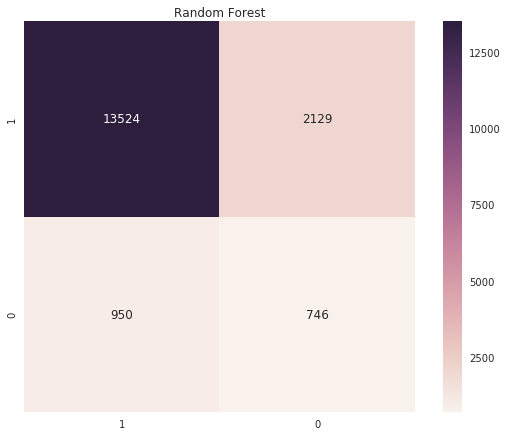

In [219]:
# creating standard confusion matrix
def standard_confusion_matrix(y_true, y_predict):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_predict)
    return np.array([[tp, fp], [fn, tn]])

# Draw a confusion matrix for the results
y_predict = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)
cm = standard_confusion_matrix(y_test, y_predict)

conf_matrix = {
                1: {
                    'matrix': cm,
                    'title': 'Random Forest',
                   }
}

# Plotting confusion matrix
fix, ax = plt.subplots(figsize=(10, 7))
# plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(1, 1, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='', square=True, \
                            xticklabels=['1', '0'], \
                            yticklabels=['1', '0']);
plt.savefig('Confusion Matrix of Various Classifiers', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)
plt.show()


In [212]:
print "precision:", precision_score(y_test, y_predict)
print "recall:", recall_score(y_test, y_predict)

precision: 0.863987733981
recall: 0.934365068399


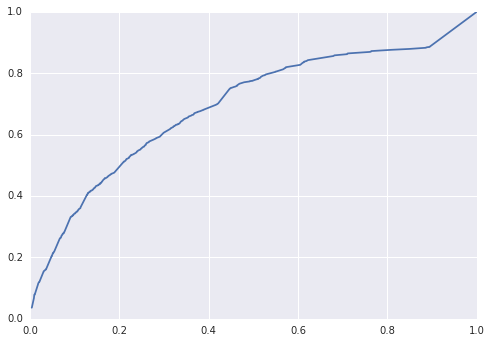

In [217]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list
    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)

    return tprs, fprs, thresholds.tolist()



# Getting true positive and false positive rates
tpr, fpr, thres = roc_curve(y_proba[:,0:1].flatten(), y_test)
# rfcru_tpr, rfcru_fpr, rfcru_thres = roc_curve(rfcru_proba[:,0:1].flatten(), y_test)
# rfcb_tpr, rfcb_fpr, rfcb_thres = roc_curve(rfcb_proba[:,0:1].flatten(), y_test)

# Plotting ROC curve
plt.plot(tpr, fpr)
# plt.savefig('ROC Curve - Random Forest with Random Under Sample', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)
plt.show()


In [220]:
rf.feature_importances_

array([ 0.46367516,  0.14531787,  0.29650332,  0.04572318,  0.01652191,
        0.03225855])

In [234]:
for name, importance in izip(cols, rf.feature_importances_):
    print round(importance,4), '\t\t', name

0.4637 		num_sessions
0.1453 		total_artists_followed
0.2965 		total_artworks_favorited
0.0457 		total_artworks_shared
0.0165 		gender_male
0.0323 		gender_unknown
